# Understand the problem and read in the data

From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, we must predict the category of crime that occurred. Please check out the Kaggle link here to see feature details - https://www.kaggle.com/c/sf-crime/overview

In [2]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from pandas.api.types import is_string_dtype,is_numeric_dtype
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import Point
import contextily as ctx
import geopandas as gpd
import geoplot as gplt
import os
import re
import shutil
import time
import urllib.request
import zipfile

In [4]:
# Load dataset
df = pd.read_csv(f'/Users/jennywen/Documents/NEU/6105/Project/train.csv',parse_dates=['Dates'])
#df = pd.read_csv(f'train.csv',parse_dates=['Dates'])
print(df.shape)
print(df.head(5))

(878049, 9)
                Dates        Category                      Descript  \
0 2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1 2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2 2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -12

In [5]:
# Check info and data types
print(df.info())
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB
None
Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object


In [6]:
# Visualize data statistics
print(df.describe())

                   X              Y
count  878049.000000  878049.000000
mean     -122.422616      37.771020
std         0.030354       0.456893
min      -122.513642      37.707879
25%      -122.432952      37.752427
50%      -122.416420      37.775421
75%      -122.406959      37.784369
max      -120.500000      90.000000


In [7]:
#take a look at our target variable
target = df["Category"].unique()
print(target)

['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']


In [8]:
#take a look at how many times each crime happened
crimes_counts = df['Category'].value_counts()
print (crimes_counts)

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

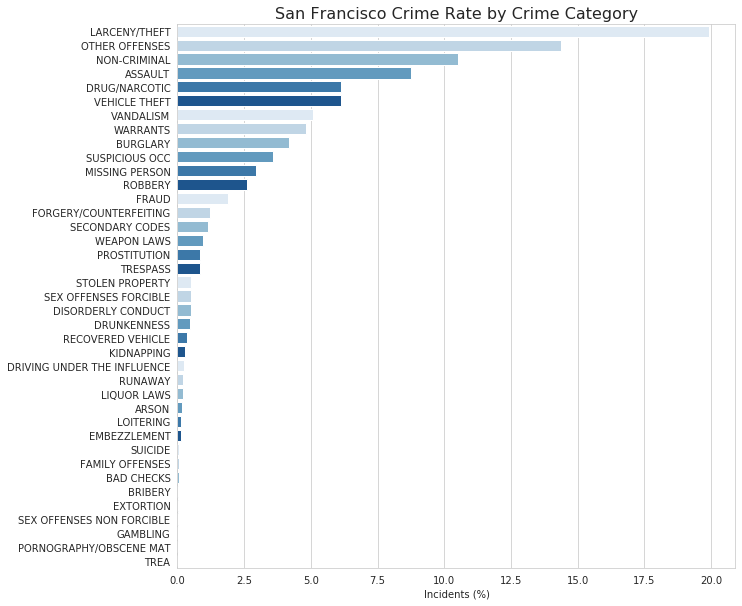

In [9]:
#Visualize crime rate by category
data = crimes_counts
plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        (data.values / data.values.sum()) * 100,
        data.index,
        orient="h",
        palette=sns.color_palette("Blues"))
plt.title("San Francisco Crime Rate by Crime Category", fontdict={"fontsize": 16})
plt.xlabel("Incidents (%)")
plt.show()

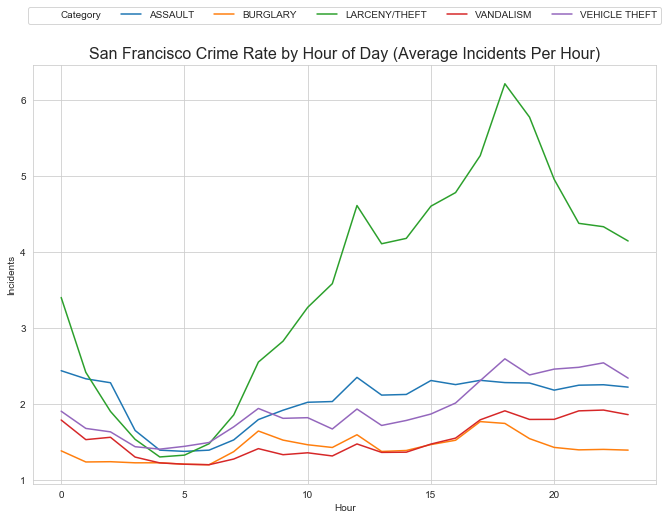

In [10]:
#Visualize crime rate by hour
df["Date"] = df.Dates.dt.date
df["Hour"] = df.Dates.dt.hour
data = df.groupby(["Hour", "Date", "Category"], as_index=False).count().iloc[:, :4]
data.rename(columns={"Dates": "Incidents"}, inplace=True)
data = data.groupby(["Hour", "Category"], as_index=False).mean()
data = data.loc[data["Category"].isin(["BURGLARY", "ASSAULT", "VEHICLE THEFT", "LARCENY/THEFT", "VANDALISM"])]
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.lineplot(x="Hour", y="Incidents", data=data, hue="Category")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=6)
plt.title("San Francisco Crime Rate by Hour of Day (Average Incidents Per Hour)", fontdict={"fontsize": 16})
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
#Visualize crime rate by region via geographical map
# Download the shapefile of the area 
url = "https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile"
with urllib.request.urlopen(url) as response, open("pd_data.zip", "wb") as out_file:
    shutil.copyfileobj(response, out_file)

# Unzip
with zipfile.ZipFile("pd_data.zip", "r") as zip_ref:
    zip_ref.extractall("pd_data")

# Load to a geopandas dataframe
for filename in os.listdir("./pd_data/"):
    if re.match(".+\.shp", filename):
        pd_districts = gpd.read_file("./pd_data/" + filename)
        break

# Define the coordinate system to longitude/latitude
pd_districts.crs={"init": "epsg:4326"}

# Merge our train dataset with the geo-dataframe
pd_districts = pd_districts.merge(
    df.groupby("PdDistrict").count().iloc[:, [0]].rename(
        columns={"Dates": "Incidents"}),
        how="inner",
        left_on="district",
        right_index=True,
        suffixes=("_x", "_y"))

# Transform the coordinate system to Spherical Mercator for compatibility with the tiling background
pd_districts = pd_districts.to_crs({"init": "epsg:3857"})

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


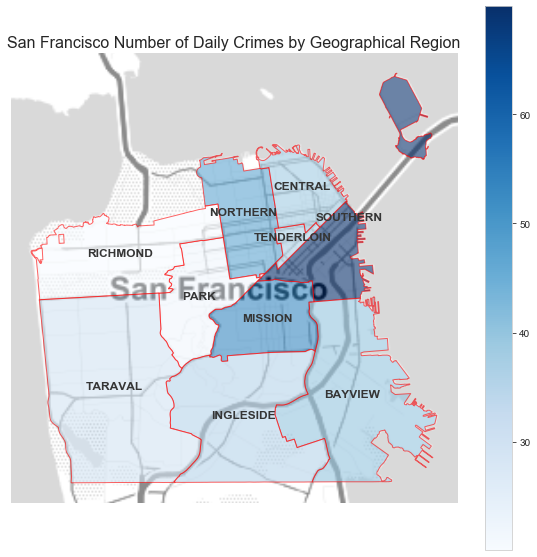

In [14]:
# Calculate incidents per day for every district
train_days = df.groupby("Date").count().shape[0]
pd_districts["inc_per_day"] = pd_districts.Incidents/train_days

# Plot data
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column="inc_per_day",
    cmap="Blues",
    alpha=0.6,
    edgecolor="r",
    linestyle="-",
    linewidth=1,
    legend=True,
    ax=ax)

def add_basemap(ax, zoom, url="http://tile.stamen.com/terrain/tileZ/tileX/tileY.png"):
    """Function that add the tile background to the map"""
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # Restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Add background
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# Add name of districts
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
         pd_districts.loc[index].geometry.centroid.y),
        color='#353535',
        fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )
ax.set_axis_off()
plt.title("San Francisco Number of Daily Crimes by Geographical Region", fontdict={"fontsize": 16})
plt.show()

In [12]:
# Create geo pandas frame
def create_gdf(df):
    gdf = df.copy()
    gdf["Coordinates"] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(gdf, geometry="Coordinates", crs={"init": "epsg:4326"})
    return gdf

train_gdf = create_gdf(df)

(878049, 12)
start


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


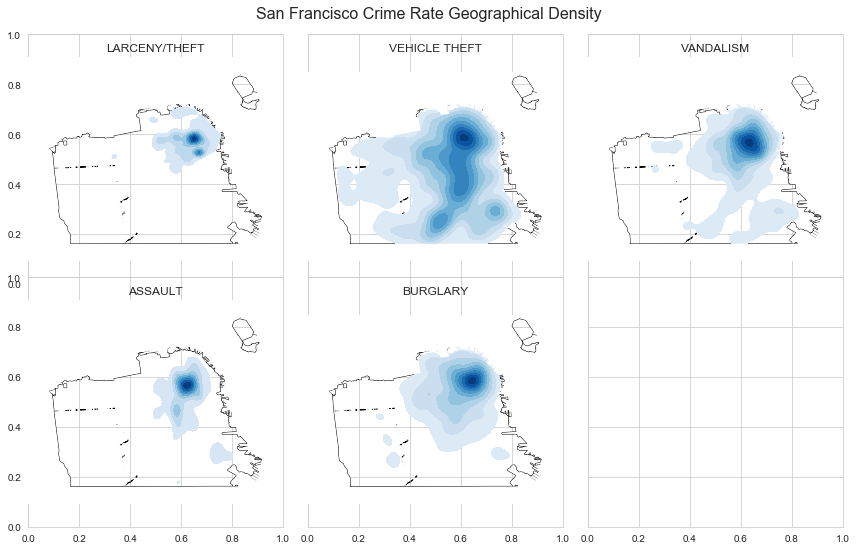

end in 56.27583149999998 seconds


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [18]:
#Visualize crime rate density by category

crimes = ["BURGLARY", "ASSAULT", "VEHICLE THEFT", "LARCENY/THEFT", "VANDALISM"]

train_gdf_2 = train_gdf[:]
print(train_gdf_2.shape)
train_gdf_2 = train_gdf_2.iloc[0:100000]

print("start")
start = time.clock()

pd_districts = pd_districts.to_crs({"init": "epsg:4326"})
sf_land = pd_districts.unary_union
sf_land = gpd.GeoDataFrame(gpd.GeoSeries(sf_land), crs={"init": "epsg:4326"})
sf_land = sf_land.rename(columns={0: "geometry"}).set_geometry("geometry")

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
for i , crime in enumerate(np.random.choice(crimes, size=5, replace=False)):
    data = train_gdf_2.loc[train_gdf_2["Category"] == crime]
    ax = fig.add_subplot(2, 3, i+1)
    gplt.kdeplot(data,
                 shade=True,
                 shade_lowest=False,
                 clip = sf_land.geometry,
                 cmap="Blues",
                 ax=ax)
    gplt.polyplot(sf_land, ax=ax)
    ax.set_title(crime) 
plt.suptitle("San Francisco Crime Rate Geographical Density", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

end = time.clock()
print("end in " + str(end - start) + " seconds")

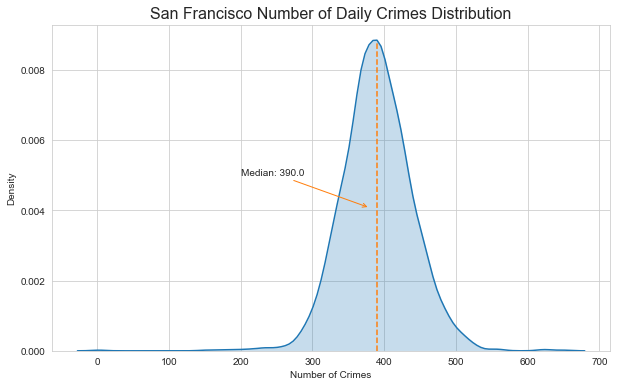

In [17]:
#Visualize crime rate distribution per day
col = sns.color_palette()

plt.figure(figsize=(10, 6))
data = df.groupby("Date").count().iloc[:, 0]
sns.kdeplot(data=data, shade=True)
plt.axvline(x=data.median(), ymax=0.95, linestyle='--', color=col[1])
plt.annotate(
    "Median: " + str(data.median()),
    xy=(data.median(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color=col[1], shrinkB=10))
plt.title("San Francisco Number of Daily Crimes Distribution", fontdict={"fontsize": 16})
plt.xlabel("Number of Crimes")
plt.ylabel("Density")
plt.legend().remove()
plt.show()

# Pre-processing

In [7]:
#We see that there are in total of 2323 rows of data that are duplicated
df.duplicated().sum()

2323

In [8]:
#Remove the duplicated rows from dataset
df = df.drop_duplicates()

In [9]:
#Verify that we have removed the duplicated rows
df.shape

(875726, 9)

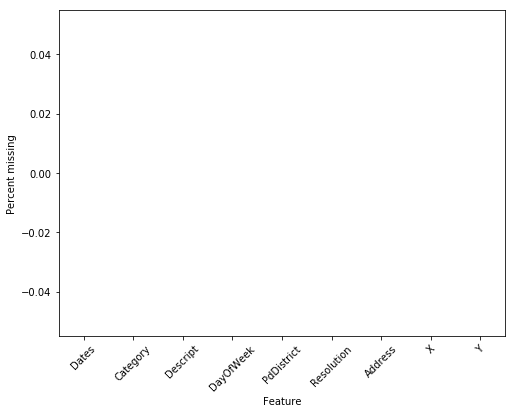

In [10]:
#Check if there is any missing value. Looks like there isn't any!

null_vals = df.isnull().sum()/len(df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

# Data Engineering

In [11]:
#Divide the column Dates into more detailed coloumns
df['Year'] = df.Dates.dt.year
df['Hour'] = df.Dates.dt.hour
df['Month'] = df.Dates.dt.month
df['DayOfMonth'] = df.Dates.dt.day
df['Minute'] = df.Dates.dt.minute

#Replacing the day of weeks
data_week_dict = {
    "Monday": 1,
    "Tuesday":2,
    "Wednesday":3,
    "Thursday":4,
    "Friday":5,
    "Saturday":6,
    "Sunday":7
}
df["DayOfWeek"] = df["DayOfWeek"].replace(data_week_dict)
df.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y', 'Year', 'Hour', 'Month',
       'DayOfMonth', 'Minute'],
      dtype='object')

In [12]:
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Hour,Month,DayOfMonth,Minute
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,3,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,23,5,13,53
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,3,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,23,5,13,53
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,3,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,23,5,13,33
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,3,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,23,5,13,30
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,3,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,23,5,13,30


In [13]:
#Drop the original Dates coloumn
df = df.drop(["Dates"],axis = 1)

In [14]:
#Drop the Resolution coloumn
df = df.drop(["Resolution"],axis = 1)

In [15]:
df.head(2)

,Category,Descript,DayOfWeek,PdDistrict,Address,X,Y,Year,Hour,Month,DayOfMonth,Minute
0,WARRANTS,WARRANT ARREST,3,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,23,5,13,53
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,3,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,23,5,13,53


In [16]:
def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [17]:
# Apply the str_to_cat function
df = str_to_cat(df)
df.head(10)

,Category,Descript,DayOfWeek,PdDistrict,Address,X,Y,Year,Hour,Month,DayOfMonth,Minute
0,WARRANTS,WARRANT ARREST,3,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,23,5,13,53
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,3,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,23,5,13,53
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,3,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,23,5,13,33
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,3,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,23,5,13,30
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,3,PARK,100 Block of BRODERICK ST,-122.438738,37.771541,2015,23,5,13,30
5,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,3,INGLESIDE,0 Block of TEDDY AV,-122.403252,37.713431,2015,23,5,13,30
6,VEHICLE THEFT,STOLEN AUTOMOBILE,3,INGLESIDE,AVALON AV / PERU AV,-122.423327,37.725138,2015,23,5,13,30
7,VEHICLE THEFT,STOLEN AUTOMOBILE,3,BAYVIEW,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015,23,5,13,30
8,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,3,RICHMOND,600 Block of 47TH AV,-122.508194,37.776601,2015,23,5,13,0
9,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,3,CENTRAL,JEFFERSON ST / LEAVENWORTH ST,-122.419088,37.807802,2015,23,5,13,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875726 entries, 0 to 878048
Data columns (total 12 columns):
Category      875726 non-null category
Descript      875726 non-null category
DayOfWeek     875726 non-null int64
PdDistrict    875726 non-null category
Address       875726 non-null category
X             875726 non-null float64
Y             875726 non-null float64
Year          875726 non-null int64
Hour          875726 non-null int64
Month         875726 non-null int64
DayOfMonth    875726 non-null int64
Minute        875726 non-null int64
dtypes: category(4), float64(2), int64(6)
memory usage: 66.0 MB


In [19]:
"""In this dataset, we will only keep X and Y, which are altitudes and latitudes, into floats.
   We will change other variables into category"""

for cols in ["DayOfWeek", "Year", "Hour", "Month", "Minute", "DayOfMonth"]:
    df[cols] = df[cols].astype('category')

In [20]:
#Check the datatype again. We have sucessfully changed them into category type.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875726 entries, 0 to 878048
Data columns (total 12 columns):
Category      875726 non-null category
Descript      875726 non-null category
DayOfWeek     875726 non-null category
PdDistrict    875726 non-null category
Address       875726 non-null category
X             875726 non-null float64
Y             875726 non-null float64
Year          875726 non-null category
Hour          875726 non-null category
Month         875726 non-null category
DayOfMonth    875726 non-null category
Minute        875726 non-null category
dtypes: category(10), float64(2)
memory usage: 30.9 MB


In [21]:
for col in ['Category', 'Descript', 'PdDistrict','Address']:
    df[col] = pd.Categorical(df[col], categories=df[col].unique()).codes


In [22]:
df.head(10)

,Category,Descript,DayOfWeek,PdDistrict,Address,X,Y,Year,Hour,Month,DayOfMonth,Minute
0,37,866,3,4,19790,-122.425892,37.774599,2015,23,5,13,53
1,21,810,3,4,19790,-122.425892,37.774599,2015,23,5,13,53
2,21,810,3,4,22697,-122.424363,37.800414,2015,23,5,13,33
3,16,404,3,4,4266,-122.426995,37.800873,2015,23,5,13,30
4,16,404,3,5,1843,-122.438738,37.771541,2015,23,5,13,30
5,16,406,3,2,1505,-122.403252,37.713431,2015,23,5,13,30
6,36,739,3,2,13322,-122.423327,37.725138,2015,23,5,13,30
7,36,739,3,0,18054,-122.371274,37.727564,2015,23,5,13,30
8,16,404,3,6,11384,-122.508194,37.776601,2015,23,5,13,0
9,16,404,3,1,17658,-122.419088,37.807802,2015,23,5,13,0


# Train-Valid-Test Split

In [23]:
"""We will split the dataset into three parts in this section"""
def df_splitter(df,num_rows):
    return df[:num_rows].copy(),df[num_rows:]

In [24]:
# Calculate 30% of 875726 
test = (30*875726)/100
print(test)

262717.8


In [25]:
df_train,df_valid_test = df_splitter(df,(875726-262717))
print(df_train.shape,df_valid_test.shape)

(613009, 12) (262717, 12)


In [26]:
#Verify the train data
df_train.head(2)

,Category,Descript,DayOfWeek,PdDistrict,Address,X,Y,Year,Hour,Month,DayOfMonth,Minute
0,37,866,3,4,19790,-122.425892,37.774599,2015,23,5,13,53
1,21,810,3,4,19790,-122.425892,37.774599,2015,23,5,13,53


In [27]:
#Verify the valid_test data
df_valid_test.head(2)

,Category,Descript,DayOfWeek,PdDistrict,Address,X,Y,Year,Hour,Month,DayOfMonth,Minute
614645,37,866,4,3,4686,-122.419672,37.765050,2006,10,8,24,20
614646,37,866,4,7,12308,-122.403405,37.775421,2006,10,8,24,18


In [28]:
# Split the valid_test data in half into validation and test sets

df_valid,df_test = df_splitter(df_valid_test,131359)
print(df_valid.shape,df_test.shape)

(131359, 12) (131358, 12)


In [29]:
#Separate out X and Y for train, test and valid
Y_train = df_train.iloc[:, :1]
X_train = df_train.iloc[:, 1:12] 

Y_valid = df_valid.iloc[:, :1]
X_valid = df_valid.iloc[:, 1:12]

Y_test = df_test.iloc[:, :1]
X_test = df_test.iloc[:, 1:12]

In [30]:
#Verify the data again after sperating x and y
X_train.head(3)

,Descript,DayOfWeek,PdDistrict,Address,X,Y,Year,Hour,Month,DayOfMonth,Minute
0,866,3,4,19790,-122.425892,37.774599,2015,23,5,13,53
1,810,3,4,19790,-122.425892,37.774599,2015,23,5,13,53
2,810,3,4,22697,-122.424363,37.800414,2015,23,5,13,33


In [31]:
Y_train.head(3)

,Category
0,37
1,21
2,21


In [32]:
X_valid.head(2)

,Descript,DayOfWeek,PdDistrict,Address,X,Y,Year,Hour,Month,DayOfMonth,Minute
614645,866,4,3,4686,-122.419672,37.765050,2006,10,8,24,20
614646,866,4,7,12308,-122.403405,37.775421,2006,10,8,24,18


In [33]:
Y_valid.head(2)

,Category
614645,37
614646,37


In [34]:
X_test.head(2)

,Descript,DayOfWeek,PdDistrict,Address,X,Y,Year,Hour,Month,DayOfMonth,Minute
746336,404,7,4,3203,-122.421649,37.786143,2004,18,10,3,30
746337,23,7,0,2692,-122.380382,37.735354,2004,18,10,3,25


In [35]:
Y_test.head(2)

,Category
746336,16
746337,20


# KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.externals import joblib

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [47]:
my_knn_model = KNeighborsClassifier(n_neighbors = 5,weights = 'uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred = my_knn_model.predict(X_valid)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [48]:
accuracy = accuracy_score(Y_valid,Y_pred)

In [49]:
print(accuracy)

0.7738868292237304


# KNN - Hyperparameter tuning

In [42]:
'''Tuning k and weights for KNN using GridSearch.'''
from sklearn.model_selection import GridSearchCV

params = {
    'n_neighbors': range(1, 10),
    'weights':['uniform','distance']
}
gs = GridSearchCV(
    KNeighborsClassifier(),
    params,
    n_jobs = -1,
    cv = 5
)

gs.fit(X_train,Y_train)

/Users/wangyouting/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': range(1, 10),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [43]:
gs.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [44]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [45]:
gs.best_score_

0.7914549378557247

In [46]:
num_neighs = list()
accuracy_list = list()
num_list = [1,2,3,4,5,6,7,8,9,10]


for neighbor in num_list:
    my_knn_model = KNeighborsClassifier(n_neighbors = neighbor,weights = 'distance')
    my_knn_model.fit(X_train,Y_train)
    Y_pred = my_knn_model.predict(X_valid)
    accuracy = accuracy_score(Y_valid,Y_pred)
    num_neighs.append(neighbor)
    accuracy_list.append(accuracy)

/Users/wangyouting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/Users/wangyouting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/Users/wangyouting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/Users/wangyouting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/Users/wangyouting/anaconda3/lib/pyt

In [47]:
'''Print it out as a table'''
eval_df =  pd.DataFrame({"Num of neighbors": num_neighs,"Valid accuracy Score": accuracy_list})
eval_df

,Num of neighbors,Valid accuracy Score
0,1,0.771984
1,2,0.771946
2,3,0.779124
3,4,0.783273
4,5,0.780251
5,6,0.780677
6,7,0.778401
7,8,0.777457
8,9,0.774443
9,10,0.773362


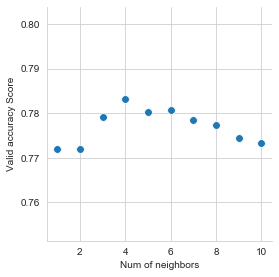

In [48]:
#Plot the above as an accuracy Vs validation set accuracy of the model
sns.set_style("whitegrid")
sns.pairplot(eval_df,x_vars = "Num of neighbors",
             y_vars = "Valid accuracy Score",plot_kws = {'s': 60},height = 4.0)

# Combining the train and validation datasets

In [42]:
'''Congrats, K = 4 seems to give the best validation 
set accuracy (= 0.783) !!! We will use this value to train our final
model.'''

X_train_full = pd.concat([X_train,X_valid],ignore_index = True)
print(X_train_full.shape)
X_train_full.head(2)

(744368, 11)


,Descript,DayOfWeek,PdDistrict,Address,X,Y,Year,Hour,Month,DayOfMonth,Minute
0,866,3,4,19790,-122.425892,37.774599,2015,23,5,13,53
1,810,3,4,19790,-122.425892,37.774599,2015,23,5,13,53


In [43]:
# Do the same for Y
Y_train_full = pd.concat([Y_train,Y_valid],ignore_index = True)
print(Y_train_full.shape)

(744368, 1)


# KNN - Try final model on test dataset

In [50]:
my_final_knn_model = KNeighborsClassifier(n_neighbors = 4,weights = 'distance')
my_final_knn_model.fit(X_train_full,Y_train_full)

#Predict on the test set
Y_final_pred = my_final_knn_model.predict(X_test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [51]:
accuracy = accuracy_score(Y_valid,Y_pred)

In [52]:
'''Yes! The final accuracy using KNN  algorithm is 0.77'''
print(accuracy)

0.7738868292237304


# Random Forest

In [39]:
mod_1 = RandomForestClassifier(n_jobs = -1, n_estimators = 10,
                                 bootstrap = True)
mod_1.fit(X_train,Y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [40]:
Y_prd = mod_1.predict(X_valid)
accuracy_score(Y_valid,Y_prd)

0.8636104111633006

In [38]:
mod_4 = RandomForestClassifier(n_jobs = -1, n_estimators = 30,
                                 bootstrap = True)
mod_4.fit(X_train,Y_train)
Y_prd4 = mod_4.predict(X_valid)
accuracy_score(Y_valid,Y_prd4)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.8937491911479228

In [56]:
mod_2 = RandomForestClassifier(n_jobs = -1, n_estimators = 100,
                                 bootstrap = True)
mod_2.fit(X_train,Y_train)
Y_prd2 = mod_2.predict(X_valid)
accuracy_score(Y_valid,Y_prd2)

/Users/wangyouting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.8947692963557884

In [36]:
mod_3 = RandomForestClassifier(n_jobs = -1, n_estimators = 200,
                                 bootstrap = True)
mod_3.fit(X_train,Y_train)
Y_prd3 = mod_3.predict(X_valid)
accuracy_score(Y_valid,Y_prd3)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.9011563729930953

In [56]:
'''Let us visualize how the above accuracy changes as number of estimators changes'''
n_estimators = [10, 30, 100, 200]
accuracy_list = [0.8636104111633006, 0.8937491911479228, 0.8947692963557884, 0.9011563729930953]

In [57]:
'''Print it out as a table'''
eval_df =  pd.DataFrame({"Num of estimators": n_estimators,"Valid accuracy Score": accuracy_list})
eval_df

,Num of estimators,Valid accuracy Score
0,10,0.863610
1,30,0.893749
2,100,0.894769
3,200,0.901156


# Random Forest - Try final model on test dataset

In [53]:
my_final_randomForest_model = RandomForestClassifier(n_jobs = -1, n_estimators = 30,
                                 bootstrap = True)
my_final_randomForest_model.fit(X_train_full,Y_train_full)

#Predict on the test set
Y_final_pred = my_final_knn_model.predict(X_test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
#The final accuracy score using the Random Forest algorithm is 0.8056! It is higher than the accuracy of KNN.
accuracy_score(Y_test,Y_final_pred)

0.8056304145921832